In [0]:
import numpy as np
import math
import torch
import torchvision
import torchvision.transforms as transforms

In [6]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


 ship


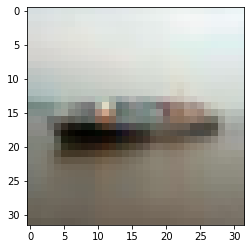

In [7]:
#https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
#Let us show some of the training images, for fun.
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(1)))

In [11]:
#getting the x(2d matrix of 50000*3072, input images), and y(1*3072, output label);
tmpTrain = trainloader.dataset.data # shape of 50000*32*32*3 need to transform to 50000*3072
x,y1,y2,y3 = tmpTrain.shape
trainX = np.zeros([x, y1*y2*y3])
tmpTrainY = trainloader.dataset.targets
trainY = np.zeros([len(tmpTrainY), len(classes)])
for i in range(len(tmpTrainY)):
  trainY[i][tmpTrainY[i]] = 1
tmpTest = testloader.dataset.data # shape of 10000*32*32*3 need to transform to 10000*3072
xx, y4, y5, y6 = tmpTest.shape
testY = testloader.dataset.targets
testX = np.zeros([xx, y4*y5*y6])
for i in range(x):
  trainX[i] = tmpTrain[i].flatten()

for j in range(xx):
  testX[j] = tmpTest[j].flatten()

print("the shape of matrix trainX" + str(trainX.shape))
print("the size of trainY " + str(trainY.shape))
print("the shape of matrix testX" + str(testX.shape))
print("the size of testY " + str(len(testY)))




the shape of matrix trainX(50000, 3072)
the size of trainY (50000, 10)
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
the shape of matrix testX(10000, 3072)
the size of testY 10000


In [5]:
#activation functions

def relu(x):
    if x > 0:
      return x
    else:
      return 0

def sigmoid(x):
  return 1/(1+math.exp(-x))

print(sigmoid(500))

1.0


In [54]:
#define weights for different layers, put them in a list called Ws, each weight has a shape of size(l-1)*size(l)
layerNumber = [1000, 300, 100, 50] #number of layers and number of nodes in each layer
AV = ReLU #activation function that we use 
Ws = []
bs = []
N,D = trainX.shape
start = D
N,DD =trainY.shape
end = layerNumber[0]
Ws.append(np.zeros([start, end]))
bs.append(np.zeros([end]))
for i in range(len(layerNumber)):
  start = layerNumber[i]
  if i+1 == len(layerNumber):
    end = DD
  else:
    end = layerNumber[i+1]
  Ws.append(np.zeros([start,end]))
  bs.append(np.zeros([end]))

print(str(bs[2].shape))

(100,)


In [55]:
def getOneLineY(X):
  Y = []
  tmp = X
  for i in range(len(Ws)-1):
    tmp = np.array([AV(xi) for xi in np.dot(tmp, Ws[i])+bs[i]])
  Y = np.array([sigmoid(xi) for xi in np.dot(tmp, Ws[len(Ws)-1])+bs[len(bs)-1]])
  return Y

def getYhead(X):
    N,D = X.shape
    Yhead = np.zeros([N, len(classes)])
    Yhead = np.array([getOneLineY(x) for x in X])
    return Yhead

print(getYhead(trainX))



[[0.5 0.5 0.5 ... 0.5 0.5 0.5]
 [0.5 0.5 0.5 ... 0.5 0.5 0.5]
 [0.5 0.5 0.5 ... 0.5 0.5 0.5]
 ...
 [0.5 0.5 0.5 ... 0.5 0.5 0.5]
 [0.5 0.5 0.5 ... 0.5 0.5 0.5]
 [0.5 0.5 0.5 ... 0.5 0.5 0.5]]


In [56]:
#Cost of one training result
def cost(Y1, Y2):
  total = 0.0
  for i in range(len(Y1)):
    total = total + (Y1[i]-Y2[i])**2
  return total


#Average cost of all training result
def averageCost(Y1, Y2):
  N,D = Y1.shape
  total = 0.0
  for i in range(N):
    total = total + cost(Y1[i],Y2[i])
  return total/N

yHead = getYhead(trainX)
print("cost is ", averageCost(yHead, testY))
  

TypeError: ignored

In [0]:
def gradient(X, Y):
  #todo, find the gradient using X,Y and Ws, bs on the top, with backpropagation
  return 0

def fit(learningRate):
  N,D = X.shape
  g = np.inf
  while np.linalg.norm(g) > eps:
    minibatch = np.random.randint(N, size=(bsize))
    g = gradient(X[minibatch,:], y[minibatch])
    w = w - lr*g

def getBiggestY(Y)
  result = []
  N,D = Y.shape
  for(i in range(N)):
    biggest = 0
    biggestNum = 0
    for(j in range(D)):
      if(Y[i][j]>biggest):
        biggestNum = j
        biggest = Y[i][j]
      result.append[biggestNum]
  return result

def predict(testX, testY):
  yHead = getYhead(testX)
  yResult = getBiggestY(yHead)
  totalRight = 0.0
  for(i in range(len(testY))):
    if(yResult[i] == testY[i]):
      totalRight = totalRight+1
  return totalRight/len(testY)
